In [1]:
# !curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# !gunzip cc.en.300.bin.gz

# around 5 minutes, you can test it on any language, just download needed model

This notebook is designed to stress test word2vec models on character removing, inserting and shuffling 

In this example, I'm using FastText, but you can use any model by passing your preferred vectorization function to the class

In [2]:
import numpy as np
from tools import WordEmbeddingsAnalyzer

import fasttext

model_name = 'cc.en.300.bin'

model = fasttext.load_model(model_name)
vectorize = model.get_word_vector

WEA = WordEmbeddingsAnalyzer(vectorizing_function=vectorize)

Let's do some experiments with any long word

In [3]:
long_word = sorted(model.get_words(), key=len)[-2] # if you are using different model, put your own word

print(f'word length: {len(long_word)}')
long_word

word length: 735


'FairsVideosArchive2017MayAprilMarchFebruaryJanuary2016DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2015DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2014DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2013DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2012DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2011DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2010DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2009DecemberNovemberOctoberSeptemberAugustJulyJuneMayAprilMarchFebruaryJanuary2008JuneMarch2007JuneAuthorsAmieCathyCharlotteDianaEllieEllie'

In [4]:
results = {'removal': dict(), 'insertion': dict(), 'shuffle': dict()}

max_n = 10 # you can try more, but it takes time
for n in range(1, max_n):
    results['removal'][n] = WEA.get_stats(long_word, 'remove', n)
    results['insertion'][n] = WEA.get_stats(long_word, 'insert', n)
    results['shuffle'][n] = WEA.get_stats(long_word, 'shuffle', n)

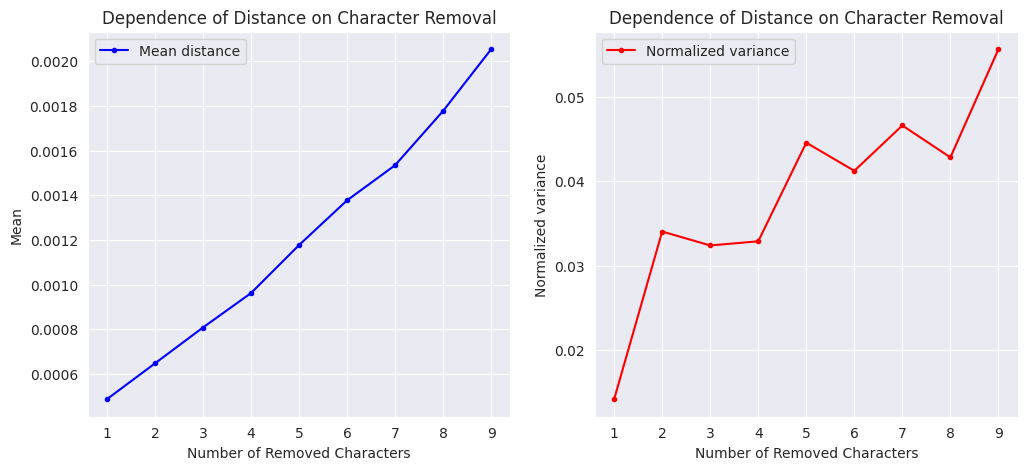

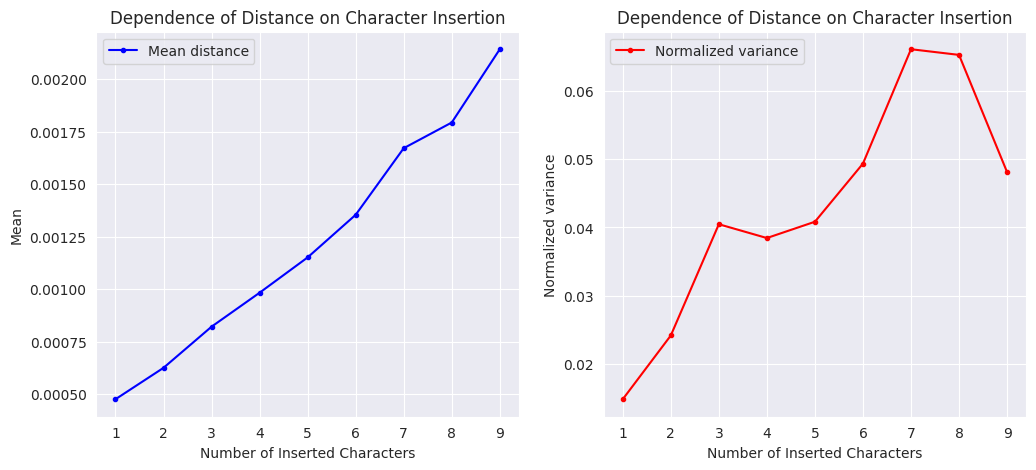

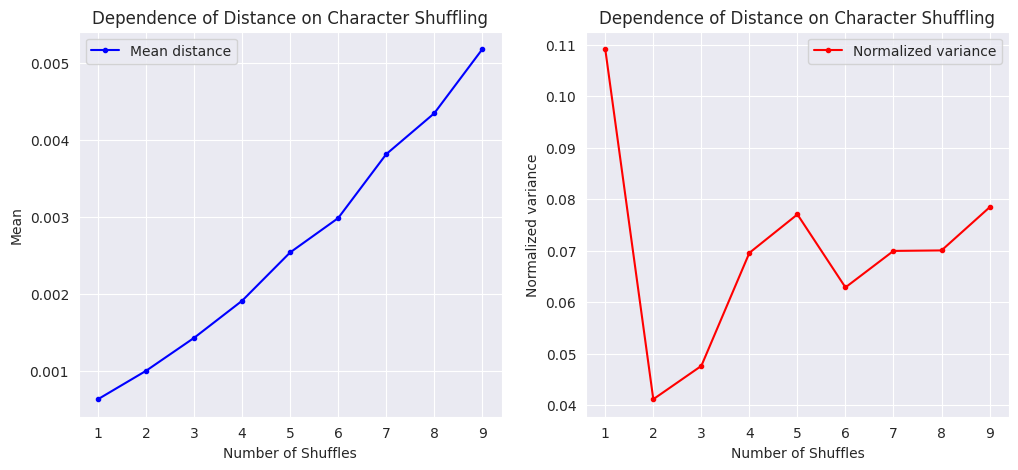

In [5]:
WEA.plot_results(results['removal'], 'Dependence of Distance on Character Removal', 'Number of Removed Characters', 'Cosine Distance')
WEA.plot_results(results['insertion'], 'Dependence of Distance on Character Insertion', 'Number of Inserted Characters', 'Cosine Distance')
WEA.plot_results(results['shuffle'], 'Dependence of Distance on Character Shuffling', 'Number of Shuffles', 'Cosine Distance')

We see that FastText is most sustainable for characters insertion and worst sustainable for shuffling.

The mean distance definetly increases monotonically with the number of operations.

It looks like this dependence is linear, but it's actually something like $y=x^{1+\epsilon}$, which can be seen if we set max_n to 100

There is not an obvious dependence in variance, but it's keep being less than $1/10$ of mean, which is good

In [6]:
WEA.get_stats(long_word, 'shuffle', 20)

(0.01897875964641571, 0.06312562032254222)

Even if we shuffle 20 pairs of characters our mean distance is $1/50$ and normalized variance is $1/20$

20 pairs for 735 characters word is only affecting 5% of it's symbols, so let's try next experiments:

1. Delete third of characters
2. Add third of characters
3. Shuffle fifth part of word

In [7]:
WEA.display_stats(long_word, 'remove', len(long_word)//3)
WEA.display_stats(long_word, 'insert', len(long_word)//3)
WEA.display_stats(long_word, 'shuffle', len(long_word)//10)

Mean distance: 0.3766, Normalized variance: 0.0112
Mean distance: 0.3366, Normalized variance: 0.0075
Mean distance: 0.1883, Normalized variance: 0.0252


So model is not this sustainable on big amount of changes, but still OK on transformations under 10% of word length

In [8]:
WEA.display_stats(long_word, 'remove', len(long_word)//10)
WEA.display_stats(long_word, 'insert', len(long_word)//10)
WEA.display_stats(long_word, 'shuffle', len(long_word)//20)

Mean distance: 0.0467, Normalized variance: 0.0492
Mean distance: 0.0558, Normalized variance: 0.0319
Mean distance: 0.0586, Normalized variance: 0.0514


Since such long words is not very usual in NLP projects, we should test it on some "real" words.

Take three words with different length and make the same test with max operations amount set to half of it's length

In [9]:
words = ['yellowbird', 'superconsciousness', 'honorificabilitudinitatibus']

In [10]:
results = {word: {'removal': dict(), 'insertion': dict(), 'shuffle': dict()} for word in words}

for word in words:
    for n in range(1, len(word)//2+1):
        results[word]['removal'][n] = WEA.get_stats(word, 'remove', n)
        results[word]['insertion'][n] = WEA.get_stats(word, 'insert', n)
        results[word]['shuffle'][n] = WEA.get_stats(word, 'shuffle', n)

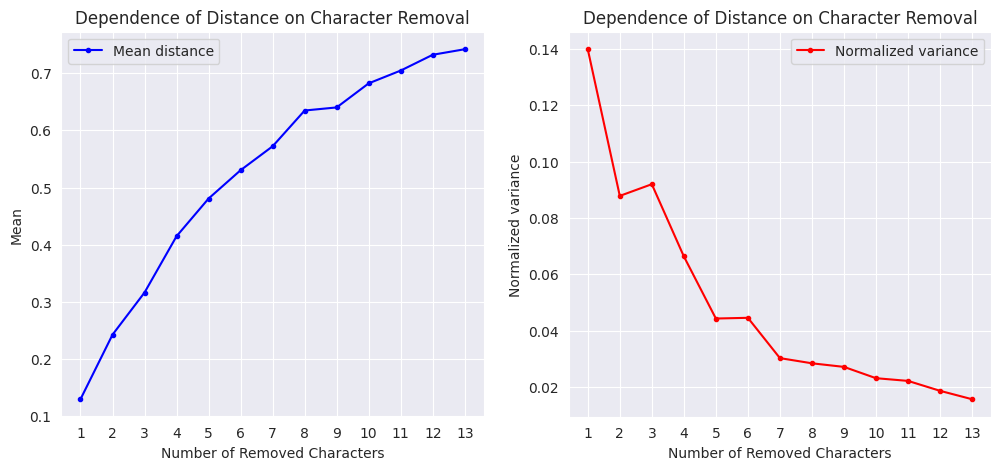

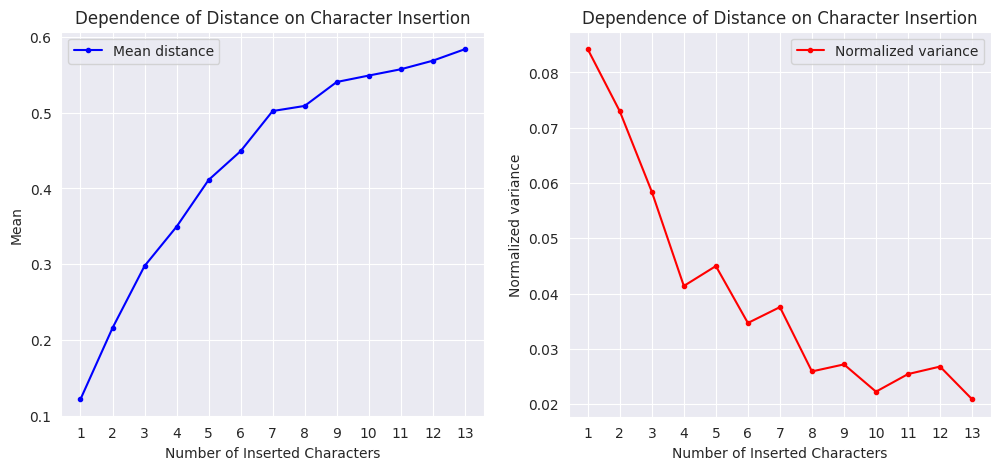

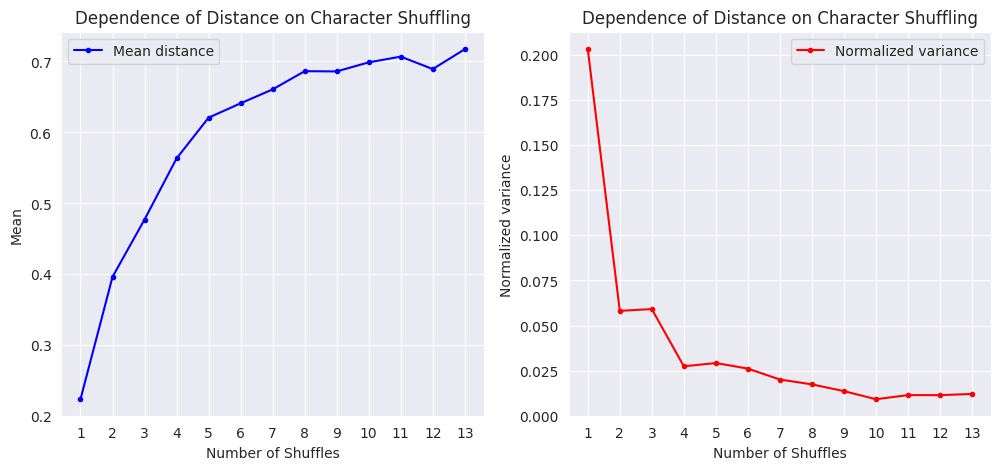

In [11]:
WEA.plot_results(results[words[2]]['removal'], 'Dependence of Distance on Character Removal', 'Number of Removed Characters', 'Cosine Distance')
WEA.plot_results(results[words[2]]['insertion'], 'Dependence of Distance on Character Insertion', 'Number of Inserted Characters', 'Cosine Distance')
WEA.plot_results(results[words[2]]['shuffle'], 'Dependence of Distance on Character Shuffling', 'Number of Shuffles', 'Cosine Distance')

So in a long word it's still fine on 1-2 elements, but even if we move to the word "superconsciousness" we got this results:

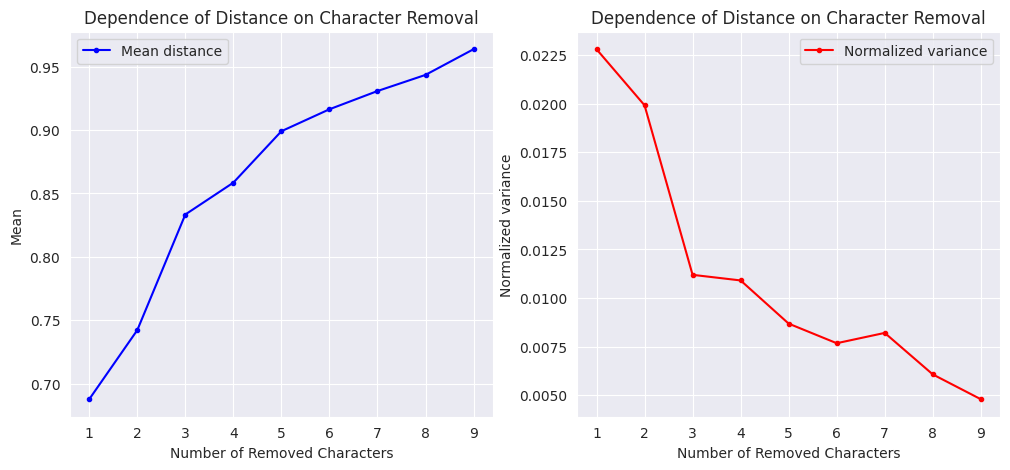

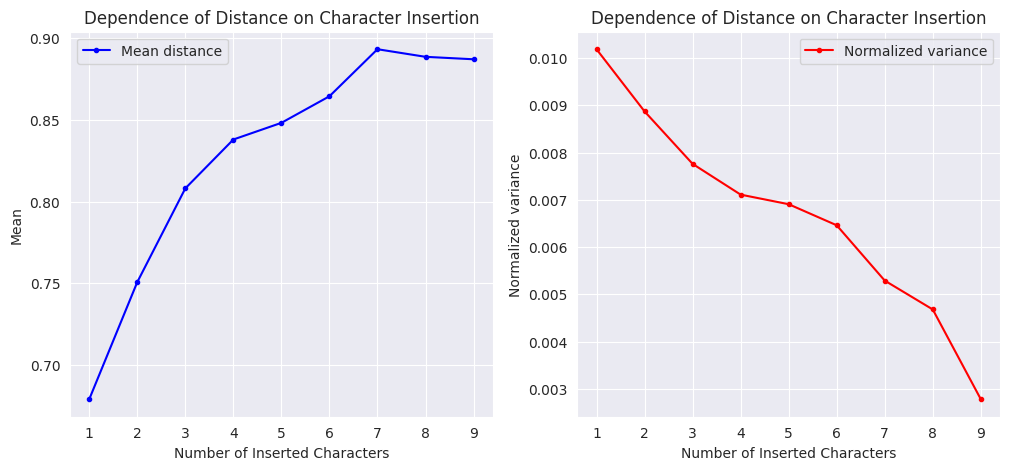

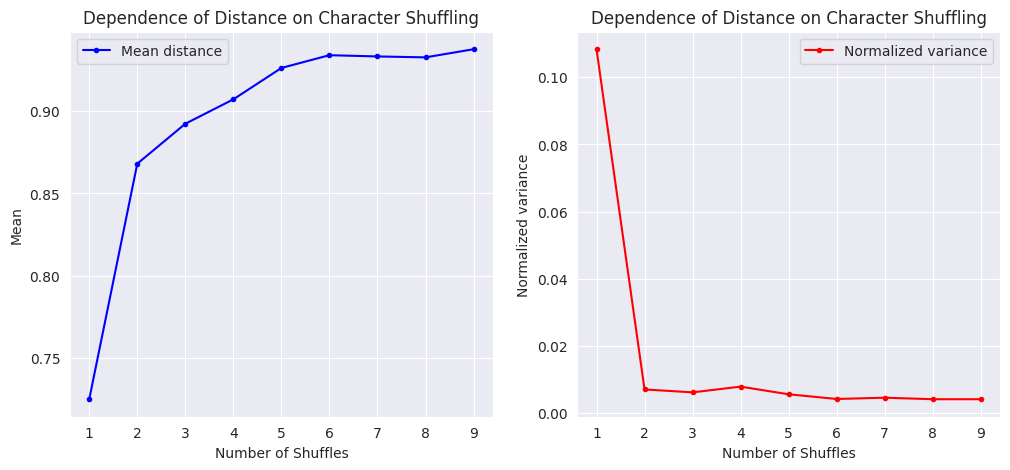

In [12]:
WEA.plot_results(results[words[1]]['removal'], 'Dependence of Distance on Character Removal', 'Number of Removed Characters', 'Cosine Distance')
WEA.plot_results(results[words[1]]['insertion'], 'Dependence of Distance on Character Insertion', 'Number of Inserted Characters', 'Cosine Distance')
WEA.plot_results(results[words[1]]['shuffle'], 'Dependence of Distance on Character Shuffling', 'Number of Shuffles', 'Cosine Distance')

Model crashes immediately, things on short words is much worse

In [13]:
WEA._cosine_distance(vectorize('black'), vectorize('blackk'))

0.7945380955934525

For example, distance between "black" and "pen" is less

In [14]:
WEA._cosine_distance(vectorize('black'), vectorize('pen'))

0.7683024108409882

Here are some examples of words that every human recognizise as the same, but distance between them is close to one.

In [15]:
print(WEA._cosine_distance(vectorize('formula'), vectorize('4mula')))
print(WEA._cosine_distance(vectorize('dependence'), vectorize('dependdence')))
print(WEA._cosine_distance(vectorize('embedding'), vectorize('embeding')))

0.7873733639717102
0.853404775261879
0.3840346336364746


Words like color/colour, favorite/favourite are absolutely the same, but model don't work well with it

In [16]:
print(WEA._cosine_distance(vectorize('color'), vectorize('colour')))
print(WEA._cosine_distance(vectorize('favorite'), vectorize('favourite')))
print(WEA._cosine_distance(vectorize('honor'), vectorize('honour')))
print(WEA._cosine_distance(vectorize('defense'), vectorize('defence')))
print(WEA._cosine_distance(vectorize('license'), vectorize('licence')))

0.22036713361740112
0.22124135494232178
0.20820027589797974
0.23635047674179077
0.18113404512405396
